# Importing Necessary Libraries

In [3]:
import re
import numpy as np
import modin.pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB,GaussianNB,MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import nltk
from nltk.tokenize import RegexpTokenizer
import opendatasets as od
import string
from wordcloud import WordCloud
from distributed import Client
client = Client()

Perhaps you already have a cluster running?
Hosting the HTTP server on port 19562 instead


# Downloading Word Lists

In [45]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\utkar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\utkar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\utkar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\utkar\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Downloading Dataset

In [46]:
od.download("https://www.kaggle.com/datasets/kazanova/sentiment140")
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv("sentiment140/training.1600000.processed.noemoticon.csv", encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.head()

Skipping, found downloaded files in ".\sentiment140" (use force=True to force download)


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Exploratory Data Analysis

In [47]:
df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  ----------------  ----- 
 0   target  1600000 non-null  int64
 1   ids     1600000 non-null  int64
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: object(4), int64(2)
memory usage: 73.2 MB


In [48]:
df.isna().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [49]:
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [50]:
df.target.unique()

array([0, 4], dtype=int64)

# Distribution Of Data Count-Plot

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

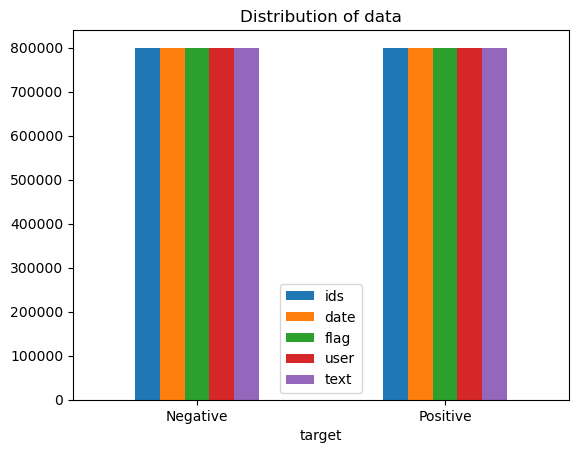

In [51]:
df.groupby("target").count().plot(kind='bar', title='Distribution of data').set_xticklabels(['Negative','Positive'], rotation=0)

# Data Augumentataion

In [52]:
dataset=df[['text','target']]
dataset['target'] = dataset['target'].replace(4,1)

In [53]:
dataset

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
1599995,Just woke up. Having no school is the best fee...,1
1599996,TheWDB.com - Very cool to hear old Walt interv...,1
1599997,Are you ready for your MoJo Makeover? Ask me f...,1
1599998,Happy 38th Birthday to my boo of alll time!!! ...,1


In [54]:
dataset.target.unique()

array([0, 1], dtype=int64)

# Data Cleaning

## &nbsp;&nbsp;&nbsp;&nbsp;Converting to Lower Case

In [55]:
dataset['text']=dataset['text'].str.lower()
dataset

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - awww, t...",0
1,is upset that he can't update his facebook by ...,0
2,@kenichan i dived many times for the ball. man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
1599995,just woke up. having no school is the best fee...,1
1599996,thewdb.com - very cool to hear old walt interv...,1
1599997,are you ready for your mojo makeover? ask me f...,1
1599998,happy 38th birthday to my boo of alll time!!! ...,1


## &nbsp;&nbsp;&nbsp;&nbsp; Replacing Contractions

In [56]:
contractions = pd.read_csv('contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']
def replace_contra(data):
    for contraction, replacement in contractions_dict.items():
        data = data.replace(contraction, replacement)
    return data
dataset['text'] = dataset['text'].apply(lambda text: replace_contra(text))
dataset

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - awww, t...",0
1,is upset that he cannot update his facebook by...,0
2,@kenichan i dived many times for the ball. man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it is not behaving at all...",0
...,...,...
1599995,just woke up. having no school is the best fee...,1
1599996,thewdb.com - very cool to hear old walt interv...,1
1599997,are you ready for your mojo makeover? ask me f...,1
1599998,happy 38th birthday to my boo of alll time!!! ...,1


In [57]:
stopwords = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s',
             'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

## &nbsp;&nbsp;&nbsp;&nbsp; Cleaning StopWords

In [58]:
def clean_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in set(stopwords)])
dataset['text'] = dataset['text'].apply(lambda text: clean_stopwords(text))
dataset.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - awww, t...",0
1,upset cannot update facebook texting it... mig...,0
2,@kenichan dived many times ball. managed save ...,0
3,whole body feels itchy like fire,0
4,"@nationwideclass no, not behaving all. mad. he...",0


## &nbsp;&nbsp;&nbsp;&nbsp; Cleaning UserNames

In [59]:
def clean_username(data):
    return re.sub('@[^\s]+',' ', data)
dataset['text'] = dataset['text'].apply(lambda x: clean_username(x))
dataset

,text,target
0,"http://twitpic.com/2y1zl - awww, thatis bumm...",0
1,upset cannot update facebook texting it... mig...,0
2,dived many times ball. managed save 50% rest...,0
3,whole body feels itchy like fire,0
4,"no, not behaving all. mad. here? cannot see ...",0
...,...,...
1599995,woke up. no school best feeling ever,1
1599996,thewdb.com - cool hear old walt interviews! â...,1
1599997,ready mojo makeover? ask details,1
1599998,happy 38th birthday boo alll time!!! tupac ama...,1


## &nbsp;&nbsp;&nbsp;&nbsp; Cleaning URLs

In [60]:
def clean_url(data):
    data=re.sub(r"((https|http|ftp)?(:\/\/)?(www\.)?)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&\/\/=]*)",' ',data)
    return re.sub(r'/', ' / ', data)
dataset['text'] = dataset['text'].apply(lambda x: clean_url(x))
dataset

,text,target
0,"- awww, thatis bummer. shoulda got david c...",0
1,upset cannot update facebook texting it... mig...,0
2,dived many times ball. managed save 50% rest...,0
3,whole body feels itchy like fire,0
4,"no, not behaving all. mad. here? cannot see ...",0
...,...,...
1599995,woke up. no school best feeling ever,1
1599996,- cool hear old walt interviews! â«,1
1599997,ready mojo makeover? ask details,1
1599998,happy 38th birthday boo alll time!!! tupac ama...,1


## &nbsp;&nbsp;&nbsp;&nbsp; Cleaning Repeating Characters

In [61]:
def clean_repeating_char(text):
    return re.sub(r"(.)\1\1+", r"\1\1", text)
dataset['text'] = dataset['text'].apply(lambda x: clean_repeating_char(x))
dataset

,text,target
0,"- aww, thatis bummer. shoulda got david carr...",0
1,upset cannot update facebook texting it.. migh...,0
2,dived many times ball. managed save 50% rest...,0
3,whole body feels itchy like fire,0
4,"no, not behaving all. mad. here? cannot see ...",0
...,...,...
1599995,woke up. no school best feeling ever,1
1599996,- cool hear old walt interviews! â«,1
1599997,ready mojo makeover? ask details,1
1599998,happy 38th birthday boo all time!! tupac amaru...,1


## &nbsp;&nbsp;&nbsp;&nbsp; Cleaning Emojis

In [62]:
def clean_emoji(data):    
    data = re.sub(r'<3', '<heart>', data)
    data = re.sub(r"[8:=;]['`\-]?[)d]+", '<smile>', data)
    data = re.sub(r"[8:=;]['`\-]?\(+", '<sad>', data)
    data = re.sub(r"[8:=;]['`\-]?[\/|l*]", '<neutral>', data)
    data = re.sub(r"[8:=;]['`\-]?p+", '<laugh>', data)
    return data
dataset['text'] = dataset['text'].apply(lambda x: clean_emoji(x))
dataset

,text,target
0,"- aww, thatis bummer. shoulda got david carr...",0
1,upset cannot update facebook texting it.. migh...,0
2,dived many times ball. managed save 50% rest...,0
3,whole body feels itchy like fire,0
4,"no, not behaving all. mad. here? cannot see ...",0
...,...,...
1599995,woke up. no school best feeling ever,1
1599996,- cool hear old walt interviews! â«,1
1599997,ready mojo makeover? ask details,1
1599998,happy 38th birthday boo all time!! tupac amaru...,1


## &nbsp;&nbsp;&nbsp;&nbsp; Cleaning Numbers

In [63]:
def clean_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: clean_numbers(x))
dataset

,text,target
0,"- aww, thatis bummer. shoulda got david carr...",0
1,upset cannot update facebook texting it.. migh...,0
2,dived many times ball. managed save % rest g...,0
3,whole body feels itchy like fire,0
4,"no, not behaving all. mad. here? cannot see ...",0
...,...,...
1599995,woke up. no school best feeling ever,1
1599996,- cool hear old walt interviews! â«,1
1599997,ready mojo makeover? ask details,1
1599998,happy th birthday boo all time!! tupac amaru s...,1


## &nbsp;&nbsp;&nbsp;&nbsp; Cleaning Punctuations

In [64]:
def clean_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))
dataset['text']= dataset['text'].apply(lambda x: clean_punctuations(x))
dataset

,text,target
0,aww thatis bummer shoulda got david carr th...,0
1,upset cannot update facebook texting it might ...,0
2,dived many times ball managed save rest go ...,0
3,whole body feels itchy like fire,0
4,no not behaving all mad here cannot see over...,0
...,...,...
1599995,woke up no school best feeling ever,1
1599996,cool hear old walt interviews â«,1
1599997,ready mojo makeover ask details,1
1599998,happy th birthday boo all time tupac amaru shakur,1


## &nbsp;&nbsp;&nbsp;&nbsp; Cleaning Non-AlphaNumeric

In [65]:
def clean_nonalpha(data):
    return re.sub("[^a-z0-9<>]", ' ', data)
dataset['text'] = dataset['text'].apply(lambda x: clean_nonalpha(x))
dataset

,text,target
0,aww thatis bummer shoulda got david carr th...,0
1,upset cannot update facebook texting it might ...,0
2,dived many times ball managed save rest go ...,0
3,whole body feels itchy like fire,0
4,no not behaving all mad here cannot see over...,0
...,...,...
1599995,woke up no school best feeling ever,1
1599996,cool hear old walt interviews,1
1599997,ready mojo makeover ask details,1
1599998,happy th birthday boo all time tupac amaru shakur,1


# Tokenization

In [66]:
dataset['text'] = dataset['text'].apply(RegexpTokenizer(r'\w+').tokenize)
dataset

,text,target
0,"[aww, thatis, bummer, shoulda, got, david, car...",0
1,"[upset, cannot, update, facebook, texting, it,...",0
2,"[dived, many, times, ball, managed, save, rest...",0
3,"[whole, body, feels, itchy, like, fire]",0
4,"[no, not, behaving, all, mad, here, cannot, se...",0
...,...,...
1599995,"[woke, up, no, school, best, feeling, ever]",1
1599996,"[cool, hear, old, walt, interviews]",1
1599997,"[ready, mojo, makeover, ask, details]",1
1599998,"[happy, th, birthday, boo, all, time, tupac, a...",1


# Snowball Stemming

In [67]:
def stem_text(data):
    return [nltk.stem.snowball.SnowballStemmer(language='english').stem(word) for word in data]
dataset['text']= dataset['text'].apply(lambda x: stem_text(x))
dataset

,text,target
0,"[aww, thati, bummer, shoulda, got, david, carr...",0
1,"[upset, cannot, updat, facebook, text, it, mig...",0
2,"[dive, mani, time, ball, manag, save, rest, go...",0
3,"[whole, bodi, feel, itchi, like, fire]",0
4,"[no, not, behav, all, mad, here, cannot, see, ...",0
...,...,...
1599995,"[woke, up, no, school, best, feel, ever]",1
1599996,"[cool, hear, old, walt, interview]",1
1599997,"[readi, mojo, makeov, ask, detail]",1
1599998,"[happi, th, birthday, boo, all, time, tupac, a...",1


# Lemmatization

In [68]:
def lemmatize_text(data):
    return [WordNetLemmatizer().lemmatize(word) for word in data]
dataset['text'] = dataset['text'].apply(lambda x: lemmatize_text(x))
dataset

,text,target
0,"[aww, thati, bummer, shoulda, got, david, carr...",0
1,"[upset, cannot, updat, facebook, text, it, mig...",0
2,"[dive, mani, time, ball, manag, save, rest, go...",0
3,"[whole, bodi, feel, itchi, like, fire]",0
4,"[no, not, behav, all, mad, here, cannot, see, ...",0
...,...,...
1599995,"[woke, up, no, school, best, feel, ever]",1
1599996,"[cool, hear, old, walt, interview]",1
1599997,"[readi, mojo, makeov, ask, detail]",1
1599998,"[happi, th, birthday, boo, all, time, tupac, a...",1


In [69]:
X=dataset.text
y=dataset.target

In [70]:
X=X.apply(lambda x: " ".join(x))
X

0          aww thati bummer shoulda got david carr third ...
1          upset cannot updat facebook text it might cri ...
2               dive mani time ball manag save rest go bound
3                            whole bodi feel itchi like fire
4            no not behav all mad here cannot see over there
                                 ...                        
1599995                     woke up no school best feel ever
1599996                         cool hear old walt interview
1599997                         readi mojo makeov ask detail
1599998    happi th birthday boo all time tupac amaru shakur
1599999                                 happi charitytuesday
Name: text, Length: 1600000, dtype: object

In [71]:
dataset[dataset.target==0].count()

text      800000
target    800000
dtype: int64

# WordCloud Visualisation

## &nbsp;&nbsp;&nbsp;&nbsp; Negative Words

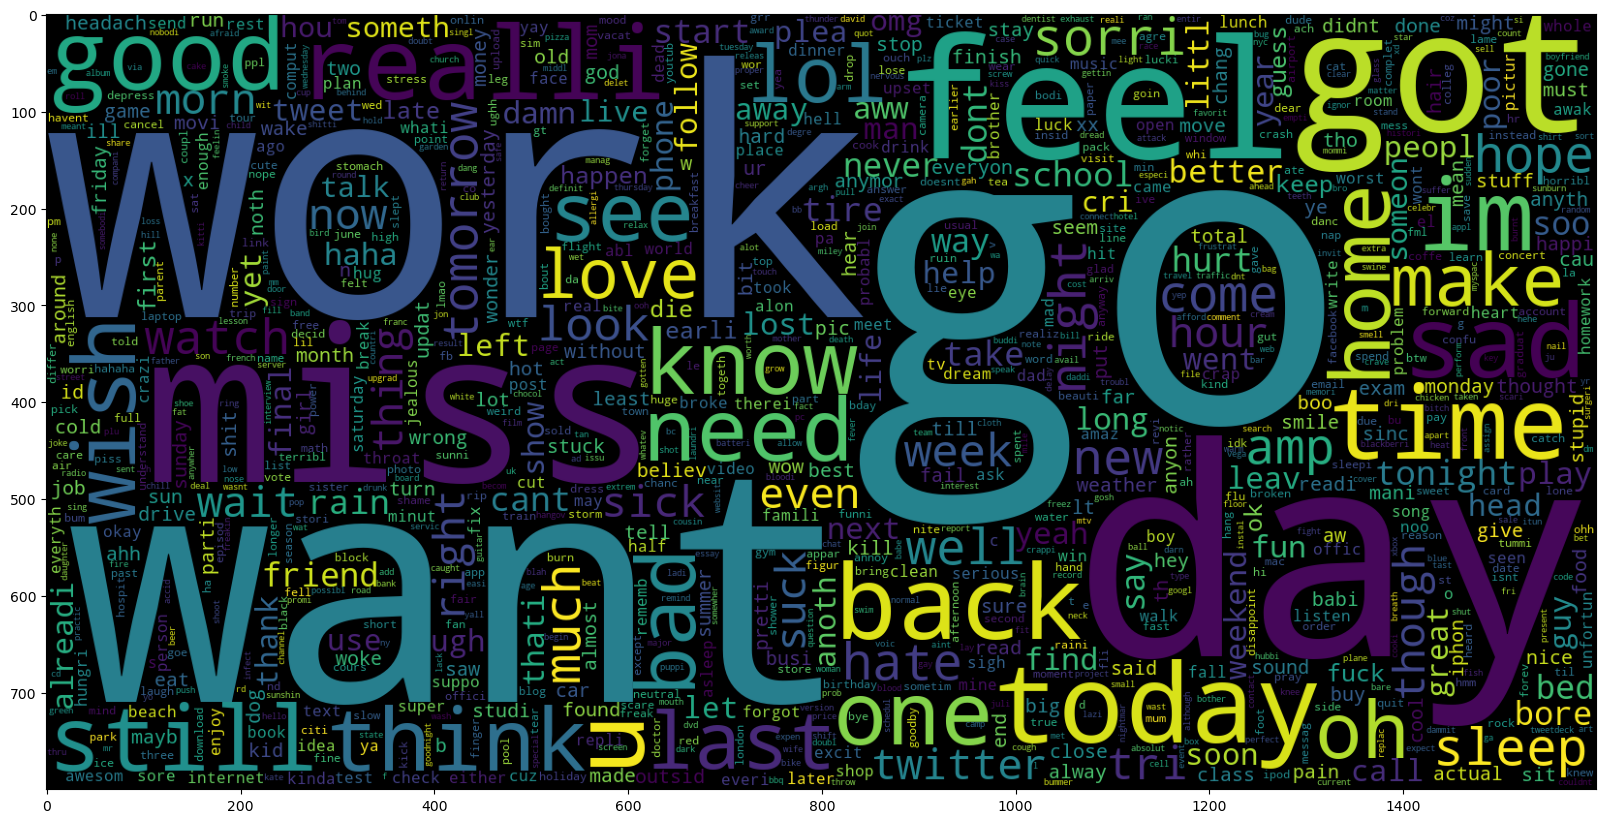

In [72]:
data_neg = dataset[dataset.target==0].text
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,collocations=False).generate(" ".join(" ".join(i) for i in data_neg))
plt.imshow(wc)

## &nbsp;&nbsp;&nbsp;&nbsp; Positive Words

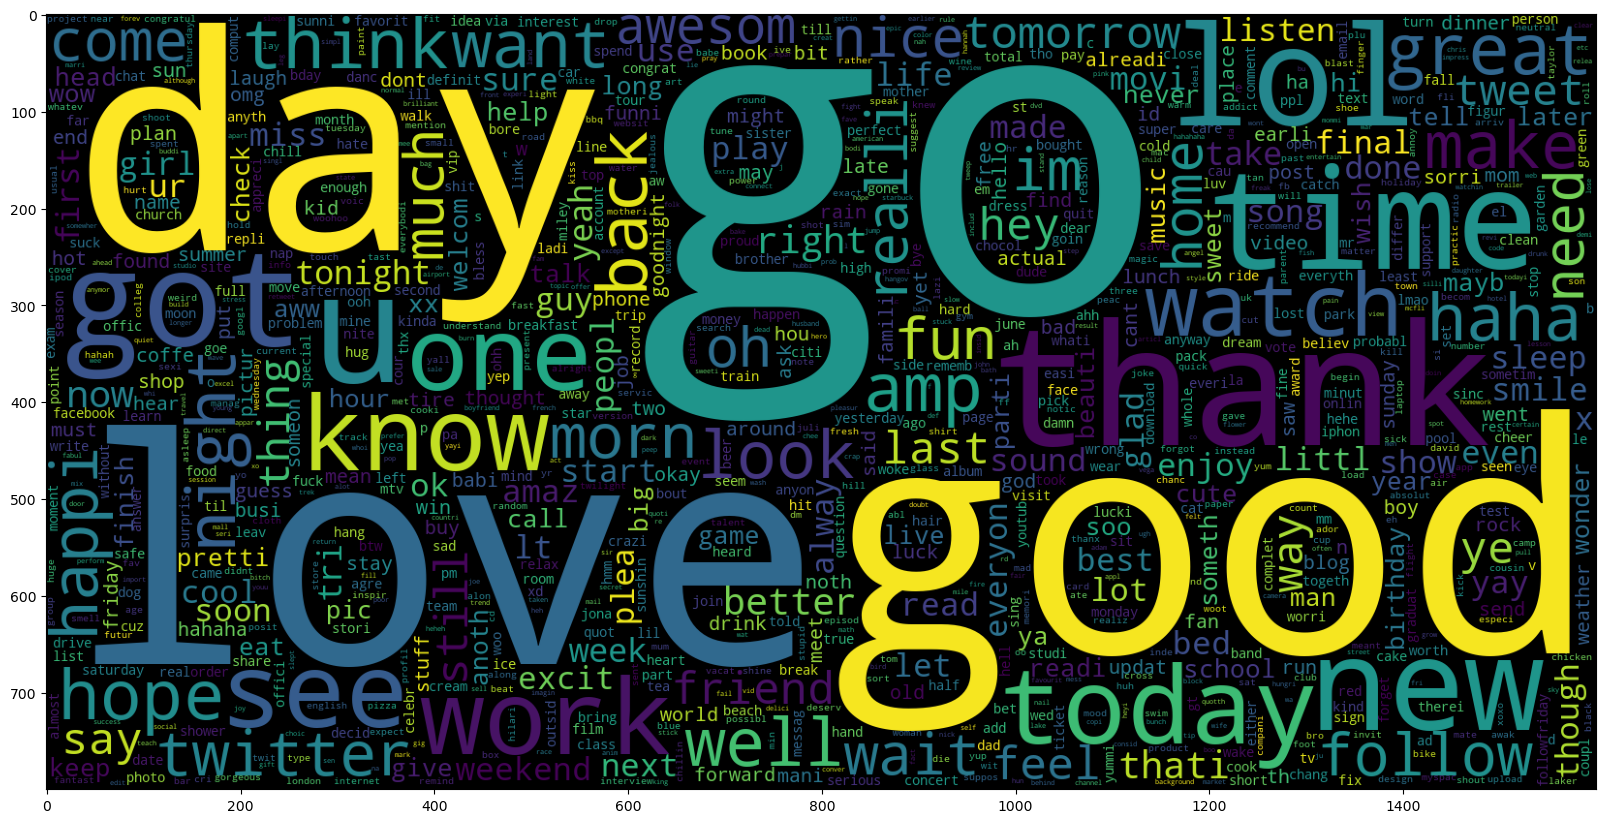

In [73]:
data_pos = dataset[dataset.target==1].text
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,collocations=False).generate(" ".join(" ".join(i) for i in data_pos))
plt.imshow(wc)

# Test Train Split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =42)

In [75]:
X_train

1374558    ya quotid like palm pre touchston charger read...
1389115            felt earthquak afternoon seem but epicent
1137831                            ruffl shirt like in likey
790714     pretti bad night crappi buttfac didnt say coul...
1117911                                      yeah clear view
                                 ...                        
259178                 songi middl chang not want born arghh
1414414                                            good luck
131932                                         rather averag
671155     pickin waitin hurri ode miss dem tabl talk bou...
121958                  home studi math woot im go fail shit
Name: text, Length: 1280000, dtype: object

# Term Frequency Inverse Document Frequncy Vectorization

In [76]:
vectoriser = TfidfVectorizer(ngram_range=(1,2))
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  3155707


In [77]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

# Model Evaluation - Confusion Matrix & ROC Curve

In [78]:
def model_Evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    sns.heatmap(cf_matrix, annot = np.asarray([f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]).reshape(2,2), cmap = 'Blues',fmt = '',xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')
    plt.legend(loc="lower right")
    plt.show()

## &nbsp;&nbsp;&nbsp;&nbsp; Bernoulli Naive Bayes

              precision    recall  f1-score   support

           0       0.80      0.78      0.79    159494
           1       0.78      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



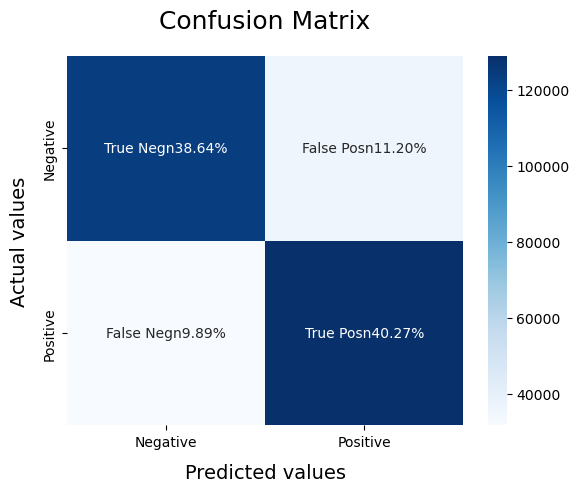

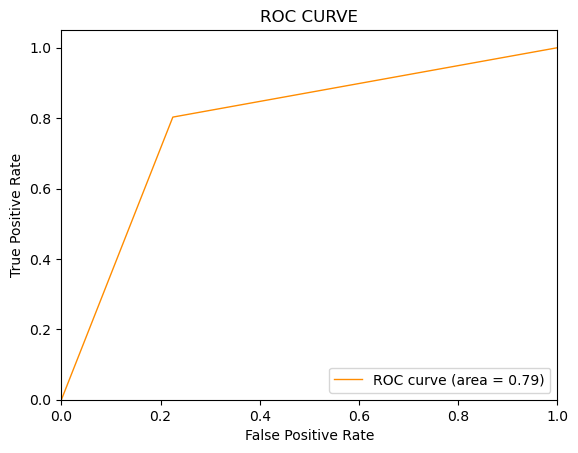

In [79]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

## &nbsp;&nbsp;&nbsp;&nbsp; Multinomial Naive Bayes

              precision    recall  f1-score   support

           0       0.77      0.83      0.80    159494
           1       0.82      0.75      0.78    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



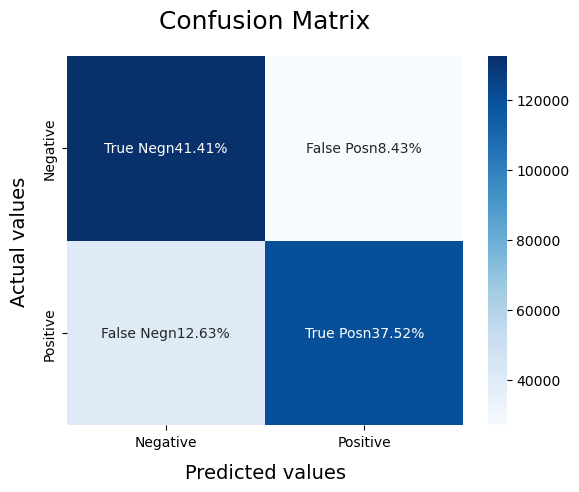

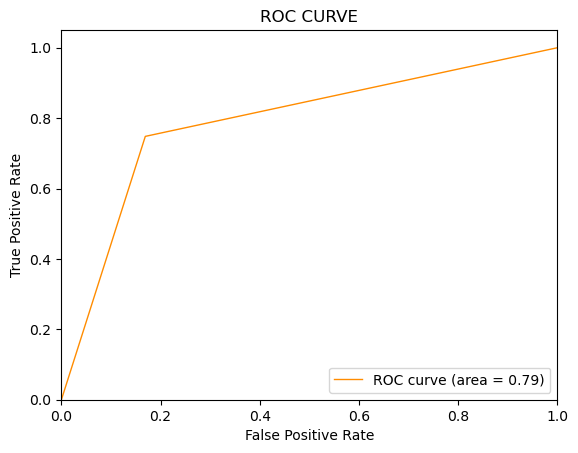

In [91]:
MNBmodel = MultinomialNB()
MNBmodel.fit(X_train, y_train)
model_Evaluate(MNBmodel)

## &nbsp;&nbsp;&nbsp;&nbsp; Linear Support Vector Machine (L-SVM)

              precision    recall  f1-score   support

           0       0.80      0.80      0.80    159494
           1       0.80      0.80      0.80    160506

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



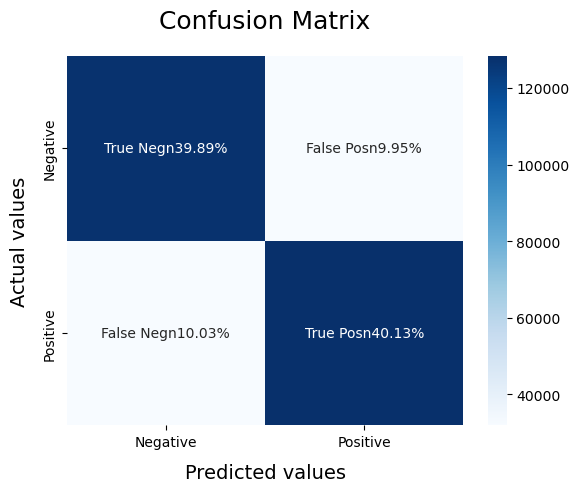

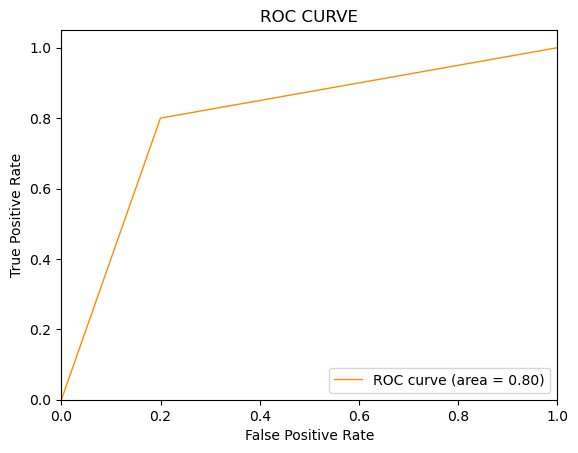

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

## &nbsp;&nbsp;&nbsp;&nbsp; Logistic Regression

              precision    recall  f1-score   support

           0       0.81      0.81      0.81    159494
           1       0.81      0.81      0.81    160506

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



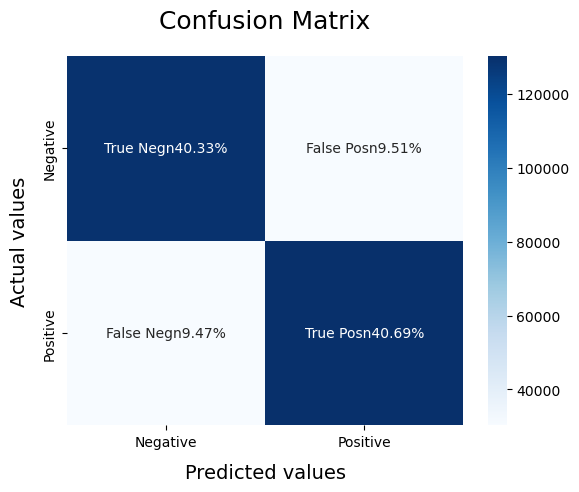

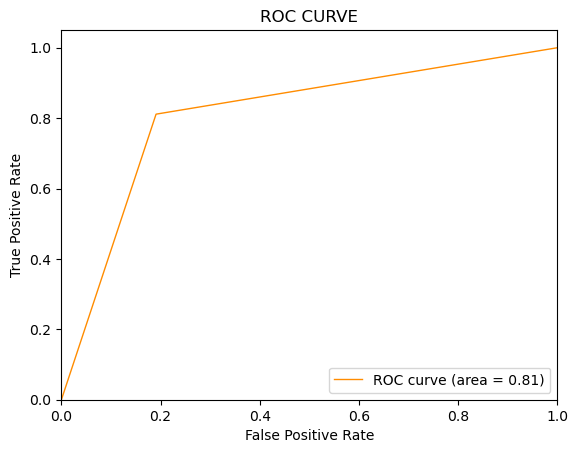

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

# Inference

## &nbsp;&nbsp;&nbsp;&nbsp;Logistic Regression is the Best of All 3